In [1]:
import numpy as np
from binomial import Binomial
from calibration import calibration
from rcn import rcn
import statsmodels.formula.api as smf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm

Interest rate  -0.0078
Dividend yield 0.0023
------------------------------
Minimum found!
Func value     0.2349
Up             1.0550
Down           0.9437
------------------------------
               simc      Call         simp       Put
Strike                                              
12000    381.425592   381.525  1662.278373  1662.321
11800    420.498776   420.599  1499.785108  1499.822
11600    493.250227   493.332  1370.970111  1370.990
11400    571.298174   571.380  1247.451609  1247.470
11200    649.346120   649.428  1123.933106  1123.951
11000    727.394066   727.476  1000.414604  1000.440
10800    805.442012   805.524   876.896102   876.917
10600    883.489958   883.572   753.377599   753.399
10400    991.348836   991.344   659.670028   659.605
10200   1114.867338  1114.862   581.622082   581.557
10000   1238.385841  1238.381   503.574136   503.509
9800    1361.904343  1361.900   425.526190   425.461
9600    1485.422845  1485.422   347.478244   347.413
9400    1612.9142

c:\users\luka\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\_minimize.py:538: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


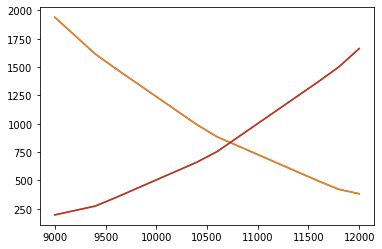

In [2]:
"""Run callibration file and return the interest rate, div yield, u and d"""
r, y, u, d = calibration()

## Question 1

In [3]:
T = 12
dt = 1/T
i0 = 11118
c = 0.1
alpha = 1
beta = 0.8

In [4]:
tree = Binomial(r, T, dt, i0, u, d, y)

print('{:10} : {:.4f}'.format(' rcn', tree.price_RCN(alpha, c)))
print('{:10} : {:.4f}'.format('brcn', tree.price_RCN(alpha, c, beta)))
print('{:10} : {:.4f}'.format('bond', tree.price_bond(c*dt)))

print()
note = rcn(r, dt, i0, y, u, d, c, T)
print('{:10} : {:.4f}'.format(' rcn', note.price_rcn(alpha=alpha, c=c)))
print('{:10} : {:.4f}'.format('brcn', note.price_brcn(alpha=alpha, beta=beta, c=c)))
print('{:10} : {:.4f}'.format('bond', note.bond))


 rcn       : 1.0117
brcn       : 1.0443
bond       : 1.1083

 rcn       : 1.0117
brcn       : 1.0542
bond       : 1.1083


## Question 2

In [25]:
par_price = 1

def f(c, *args):
    alpha, beta, type = args
    if type == 'RCN': p = tree.price_RCN(alpha, c)
    if type == 'BRCN': p = tree.price_RCN(alpha, c, beta)
    return (par_price - p) ** 2

res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN'))
res_BRCN = minimize(f, 0, args=(alpha, beta, 'BRCN'))
print('alpha = {}, beta = {}'.format(alpha, beta))
if res_RCN.success: print('Par coupon for RCN:  c = {:.2%}'.format(res_RCN.x[0]))
if res_BRCN.success: print('Par coupon for BRCN: c = {:.2%}'.format(res_BRCN.x[0]))

alpha = 1.00000001, beta = 1.0
Par coupon for RCN:  c = 8.83%
Par coupon for BRCN: c = 8.83%


In [26]:
res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN'))
rates = [0.4,0.6,0.8,1]
alphas = np.linspace(0.6, 1, 10)
betas = np.outer(alphas, rates)

cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
        {'type': 'ineq', 'fun': lambda x: x - 0})

rcn_c = []
brcn_c = np.zeros_like(betas)

for i, b in enumerate(tqdm(betas)):
    alpha = alphas[i]
    res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN'), constraints=cons)
    rcn_c.append(res_RCN.x[0]*100)
    for j, beta in enumerate(b):
        res_BRCN = minimize(f, 0, args=(alpha, beta, 'BRCN'), constraints=cons)
        brcn_c[i,j] = res_BRCN.x[0]*100

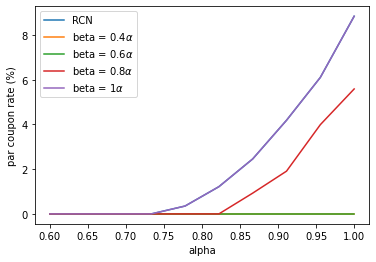

In [27]:
plt.plot(alphas, rcn_c)
for c in brcn_c.T:
    plt.plot(alphas, c)
plt.xlabel('alpha')
plt.ylabel('par coupon rate (%)')
plt.legend(['RCN'] + [r'beta = {}$\alpha$'.format(r) for r in rates])
plt.show()

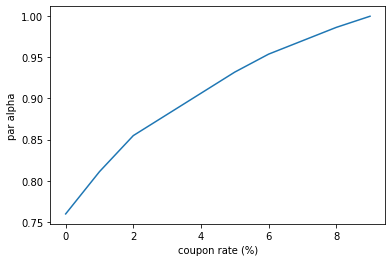

In [34]:
coupons = np.linspace(0, 0.09, 10)
par_price = 1


cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
        {'type': 'ineq', 'fun': lambda x: x - 0})

def g(alpha, *args):
    c, = args
    return (par_price - tree.price_RCN(alpha, c)) ** 2

alphas = []
for c in coupons:
    res = minimize(g, 1, args=(c), constraints=cons)
    alphas.append(res.x[0])

plt.plot(coupons*100, alphas)
plt.xlabel('coupon rate (%)')
plt.ylabel('par alpha')
plt.show(tree.price_RCN(alpha, c))

In [30]:
def h(alpha, *args):
    c, rate = args
    return (par_price - tree.price_RCN(alpha, c, rate*alpha)) ** 2


coupons = np.linspace(0, 0.09, 10)
rates = [0.4, 0.6, 0.8, 1]
#betas = np.outer(coupons, rates)

cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
        {'type': 'ineq', 'fun': lambda x: x - 0})

brcn_alpha = []

for i, r in enumerate(rates):
    row= []
    for j, c in enumerate(tqdm(coupons)):
        c = coupons[j]
        if r==0.4 or r==0.6:
            start = 1
        else:
            start=0.85
        res_BRCN = minimize(h, start, args=(c, r), constraints=cons)
        row.append(res_BRCN.x[0])
        #print(res_BRCN.x[0])
    # print(row)
    brcn_alpha.append(row)
# print(brcn_alpha)

100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


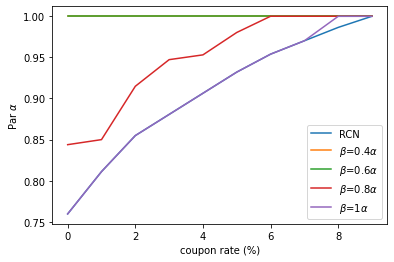

In [33]:
plt.plot(coupons*100, alphas, label='RCN')

for i, r in enumerate(rates):
    plt.plot(coupons*100, brcn_alpha[i], label=r'$\beta$={}$\alpha$'.format(r))
    plt.xlabel('coupon rate (%)')
    plt.ylabel(r'Par $\alpha$')

plt.legend()
plt.show()

#Q6-7-8

In [35]:
dates = [i for i in range(int(T/dt)+1)]
alpha = 1
c = 0.1
beta = 0.8
dates = [j for j in range(1, T)]
RCN = note.price_rcn(alpha=alpha, c=c, dates=dates)
BRCN = note.price_brcn(alpha=alpha, c=c, beta=0.8, dates=dates)
print('Price of callable simple RCN {:.4f}\nPrice of callable barrier RCN {:.4f}'.format(RCN, BRCN))

Price of callable simple RCN 0.9920
Price of callable barrier RCN 1.0008


In [36]:
par_price = 1

def f(c, *args):
    alpha, beta, type, dates = args
    if type == 'RCN': p = note.price_rcn(alpha, c, dates)
    if type == 'BRCN': p = note.price_brcn(alpha, beta, c, dates)
    return (par_price - p) ** 2

cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
        {'type': 'ineq', 'fun': lambda x: x })


rates = [0.4,0.6,0.8,1]
alphas = np.linspace(0.6, 1, 10)
betas = np.outer(alphas, rates)

rcn_c = []
brcn_c = np.zeros_like(betas)

for i, b in enumerate(tqdm(betas)):
    alpha = alphas[i]
    res_RCN = minimize(f, 0, args=(alpha, beta, 'RCN', dates), constraints=cons)
    rcn_c.append(res_RCN.x[0]*100)
    for j, beta in enumerate(b):
        res_BRCN = minimize(f, 0, args=(alpha, beta, 'BRCN', dates), constraints=cons)
        brcn_c[i,j] = res_BRCN.x[0]*100

100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


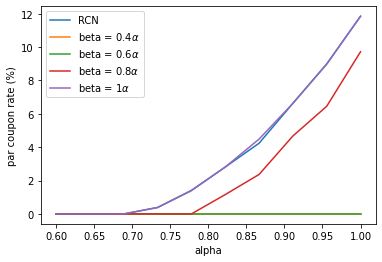

In [37]:
plt.plot(alphas, rcn_c)
for c in brcn_c.T:
    plt.plot(alphas, c)
plt.xlabel('alpha')
plt.ylabel('par coupon rate (%)')
plt.legend(['RCN'] + [r'beta = {}$\alpha$'.format(r) for r in rates])
plt.show()

Optimization method does not work, we did grid search instead

In [ ]:
# def h(alpha, *args):
#     c, r, type, dates = args
#     if type == 'RCN': p = note.price_rcn(alpha, c, dates)
#     if type == 'BRCN': p = note.price_brcn(alpha, r*alpha, c, dates)
#     return (par_price - p) ** 2
#
#
# coupons = np.linspace(0, 0.09, 15)
# rates = [0.4, 0.6, 0.8, 1]
# #betas = np.outer(coupons, rates)
#
# cons = ({'type': 'ineq', 'fun': lambda x: 1 - x},
#         {'type': 'ineq', 'fun': lambda x: x - 0.5})
#
# brcn_alpha = []
#
# for i, r in enumerate(rates):
#     row= []
#     for j, c in enumerate(tqdm(coupons)):
#         c = coupons[j]
#         if r==0.4 or r==0.6:
#             start = 0.7
#         else:
#             start=0.7
#         res_BRCN = minimize(h, start, args=(c, r, 'BRCN', dates), constraints=cons)
#         row.append(res_BRCN.x[0])
#         #print(res_BRCN.x[0])
#     # print(row)
#     brcn_alpha.append(row)
# # print(brcn_alpha)
#

In [108]:
# for i, r in enumerate(rates):
#     plt.plot(coupons*100, brcn_alpha[i], label=r'$\beta$={}$\alpha$'.format(r))
#     plt.xlabel('coupon rate (%)')
#     plt.ylabel(r'Par $\alpha$')
#
# plt.legend()
# plt.show()

Grid Search

In [109]:
coupons = np.linspace(0., 0.12, 15)
alphas = np.linspace(0.6, 1, 100)
rates = [0.4, 0.6, 0.8, 1]

par_alph = np.zeros([len(rates), coupons.shape[0]])
for n, r in enumerate(rates):
    dist = np.zeros([alphas.shape[0], coupons.shape[0]])
    for j, c in enumerate(tqdm(coupons)):
        for i, a in enumerate(alphas):
            p = note.price_brcn(a, r*a, c, dates)
            dist[i, j] = (1 - p)**2
    min_alpha_ind = np.argmin(dist, axis=0)
    par_alph[n, :] = alphas[min_alpha_ind]

100%|██████████| 15/15 [01:28<00:00,  5.91s/it]


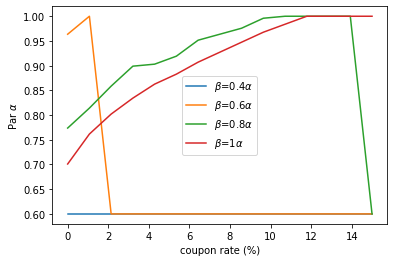

In [110]:
for i, r in enumerate(rates):
    plt.plot(coupons*100,  par_alph[i], label=r'$\beta$={}$\alpha$'.format(r))
    plt.xlabel('coupon rate (%)')
    plt.ylabel(r'Par $\alpha$')

plt.legend()
plt.show()